In [1]:
import BOX_1 as B
import numpy as np
import matplotlib.pyplot as plt

In [2]:
step_tot = 10**7
check_step = 1000

In [3]:
box = B.BOX(100,100,0.,0.,[2.5,0.],0.1)
av_c_size = np.zeros(check_step,dtype=float)
acceptance = list()
for n_steps in range(check_step):
    moves = np.array(box.monte_carlo_steps(step_tot//check_step))
    acceptance.append(np.where(moves==True)[0].shape[0]/step_tot/check_step)
    av_c_size[n_steps] = np.mean(box.cluster_size())

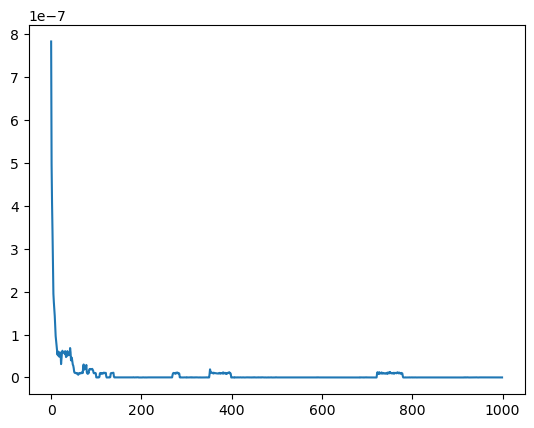

In [4]:
plt.plot(acceptance)

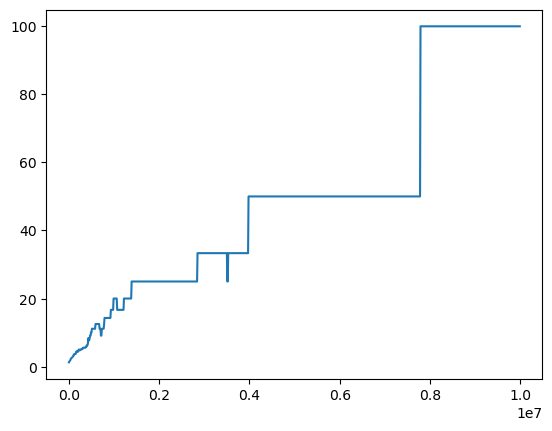

In [5]:
plt.plot([i*(step_tot//check_step) for i in range(check_step)],av_c_size)

In [6]:
box.cluster_size()

array([100])

In [3]:
import MC_frontend
step_tot = 10**7

In [4]:
mc = MC_frontend.MC(100,100,0,0,[[0.,0.,0.],[0.,2.5,0.],[0.,0.,0.]],0.,0.1)
av_c_size = np.zeros(check_step,dtype=float)
acceptance = list()
for n_steps in range(check_step):
    moves = np.array(mc.monte_carlo_steps(step_tot//check_step))
    acceptance.append(np.where(moves==True)[0].shape[0]/step_tot/check_step)
    av_c_size[n_steps] = np.mean(mc.get_cluster_size())

polymer successfully generated
particles successfully added


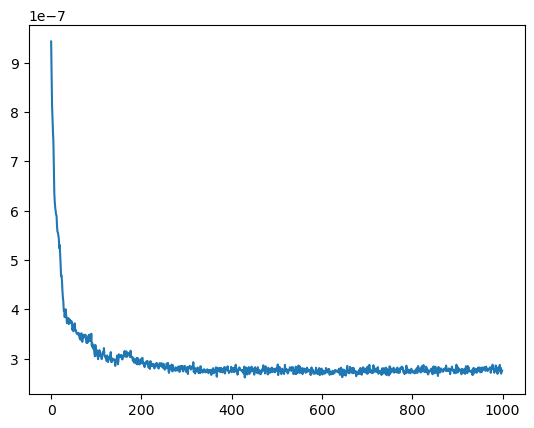

In [5]:
plt.plot(acceptance)

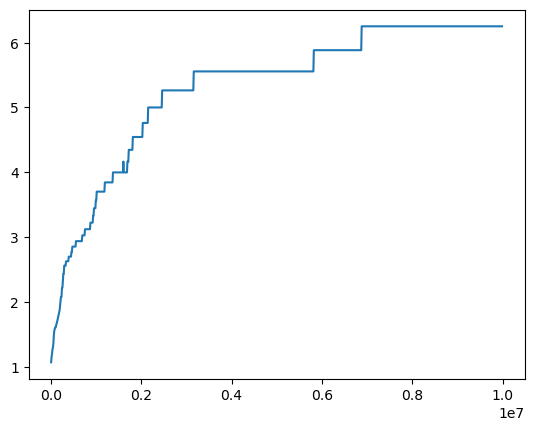

In [6]:
plt.plot([i*(step_tot//check_step) for i in range(check_step)],av_c_size)

In [7]:
mc.get_cluster_size()

array([27, 73])

In [8]:
mc.get_clusters()

(array([237218, 247319, 257419, 267419, 267319, 267318, 267317, 267218,
        267217, 257318, 257418, 257319, 257219, 257218, 257317, 257217,
        257216, 257117, 257118, 247219, 247318, 247418, 247317, 247218,
        247217, 247118, 237318, 419431, 429532, 439632, 449632, 459631,
        459532, 459531, 459530, 459529, 459430, 459431, 459432, 459433,
        459333, 459332, 459331, 459232, 459231, 449332, 449433, 449533,
        449532, 449631, 449630, 449629, 449530, 449531, 449432, 449431,
        449430, 449529, 439630, 439631, 439532, 439533, 439434, 449333,
        449233, 449232, 449331, 449330, 439431, 439531, 439530, 439529,
        439430, 439331, 439432, 439433, 439334, 439333, 439332, 439233,
        439232, 439231, 429332, 429433, 429533, 429632, 429631, 429531,
        429530, 429431, 429432, 429333, 429232, 429331, 429430, 419531,
        419631, 419532, 419432, 419530], dtype=int32),
 array([ 0, 27], dtype=int32))

In [8]:
MC_frontend.plot_simulation(mc)

/media/hcleroy/anaconda3/lib/python3.11/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
